# Eligibility for Loans Prediction

## Source:
https://www.kaggle.com/datasets/devzohaib/eligibility-prediction-for-loan

## Business Problem Statement

A company called Dream Housing Finance is trying to automate their processes for Loan Eligibility. Right now, the customers apply for the Home Loan and the company has to validate it. What they want to do is to automate this process based on a filling online application form where each customer will provide its details. This is the Dataset that was provided by the company, it includes the details for each previous Loans and the details that have to be provided by the customer. 

In [1]:
#Used for loading data, splitting, graphs
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#Used for Feature Engineering
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

#Used for modelling
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#Evaluation
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score,
                             recall_score, PrecisionRecallDisplay,auc, roc_curve, RocCurveDisplay)


# Data Collection

First we load the Dataset and set Loan ID as the Index, in a real case scenario this might be useful for future reference.


In [2]:
df = pd.read_csv('Loan_data.csv')
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [3]:
df.set_index(['Loan_ID'],inplace=True)
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
print("Rows: ", df.shape[0], "\tColumns: ", df.shape[1])

Rows:  614 	Columns:  12


## We split the Dataset into Training and Test to avoid Data Leakage

In [5]:
df_train, df_test= train_test_split(df)


print('Training set: \n', "Rows: ", df_train.shape[0], "\tColumns: ", df_train.shape[1])
print('Test set: \n', "Rows: ", df_test.shape[0], "\tColumns: ", df_test.shape[1])

Training set: 
 Rows:  460 	Columns:  12
Test set: 
 Rows:  154 	Columns:  12


## Data Exploration: 
In this step we will do the following:
- Visualizing Data
- Identifying Data Quality Issues
- Identifying Feature Engineering techniques and Evaluation metrics

#### Checking Categorical and Numerical Columns

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460 entries, LP002161 to LP001616
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             448 non-null    object 
 1   Married            457 non-null    object 
 2   Dependents         447 non-null    object 
 3   Education          460 non-null    object 
 4   Self_Employed      439 non-null    object 
 5   ApplicantIncome    460 non-null    int64  
 6   CoapplicantIncome  460 non-null    float64
 7   LoanAmount         447 non-null    float64
 8   Loan_Amount_Term   450 non-null    float64
 9   Credit_History     424 non-null    float64
 10  Property_Area      460 non-null    object 
 11  Loan_Status        460 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 46.7+ KB


#### Checking for Null values
We have quite some rows,because we have a small quantity of entries in our data, removing all the null values will lead to a low model performance. The more the data, the better, for this reason I will impute the mode of each. On the other hand, I consider the Credit History feature a really important feature for the Banks being that it is a straightforward indicator that tells if the Applicant has met the guidelines, for this reason I will remove this column.

In [7]:
df_train.isnull().sum()

Gender               12
Married               3
Dependents           13
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           13
Loan_Amount_Term     10
Credit_History       36
Property_Area         0
Loan_Status           0
dtype: int64

#### Functions for getting Categorical and Numerical Columns of a given Dataset
The functions take a dataframe and get the column names as a list. Then it iterates over and checks for the Dtype of the columns, if the dtype is a float or an int, it will store it on numerical columns, if dtype is an object it will store it in categorical columns.

In [8]:
def get_catcolumns(dataframe):
    categorical_columns = []
    
    for i in dataframe.columns:
        if(dataframe[i].dtype != np.float64 and dataframe[i].dtype != np.int64):
            categorical_columns.append(i)

    return categorical_columns

def get_numcolumns(dataframe):
    numerical_columns = []
    
    for i in dataframe.columns:
        if(dataframe[i].dtype == np.float64 or dataframe[i].dtype == np.int64):
            numerical_columns.append(i)
    
    return numerical_columns


In [9]:
print('Cat:',get_catcolumns(df_train), '\n Num:', get_numcolumns(df_train))

Cat: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status'] 
 Num: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


### Plotting Categorical Graphs graphs


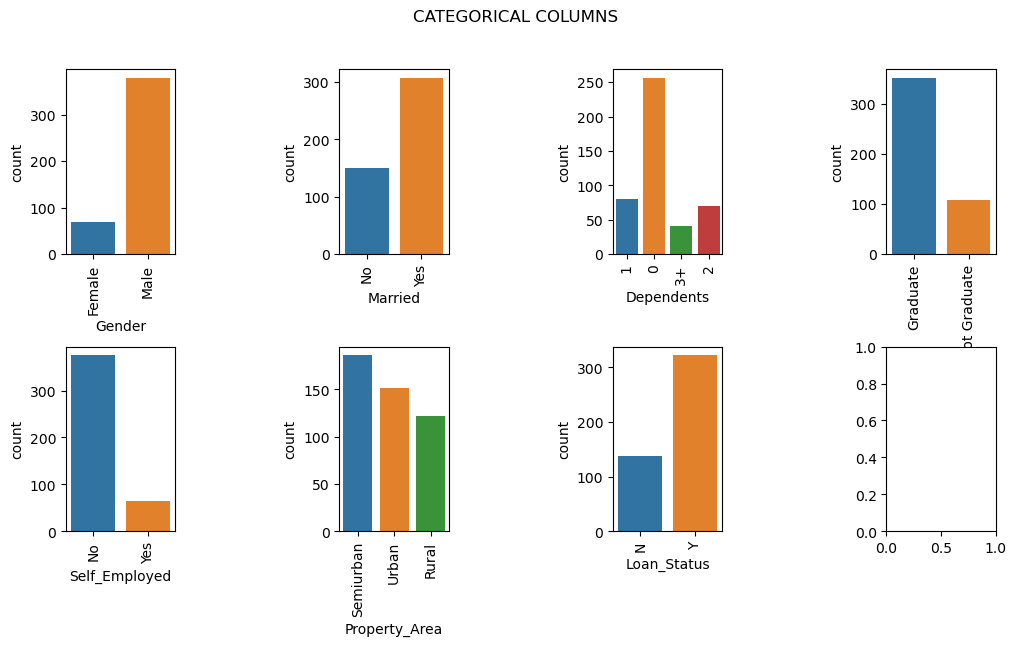

In [10]:
cat = get_catcolumns(df_train)
n_cols = 4
n_rows = (len(cat) - 1) // n_cols + 1

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6))
fig.subplots_adjust(hspace=0.5, wspace=1.5)
fig.suptitle('CATEGORICAL COLUMNS')

for i, column in enumerate(cat):
    ax = axes.flat[i]
    sns.countplot(x=df_train[column], ax=ax)
    ax.set_xlabel(cat[i])
    ax.tick_params(axis='x', labelrotation=90)

plt.show()


### Ploting Numerical Columns on Loan Status

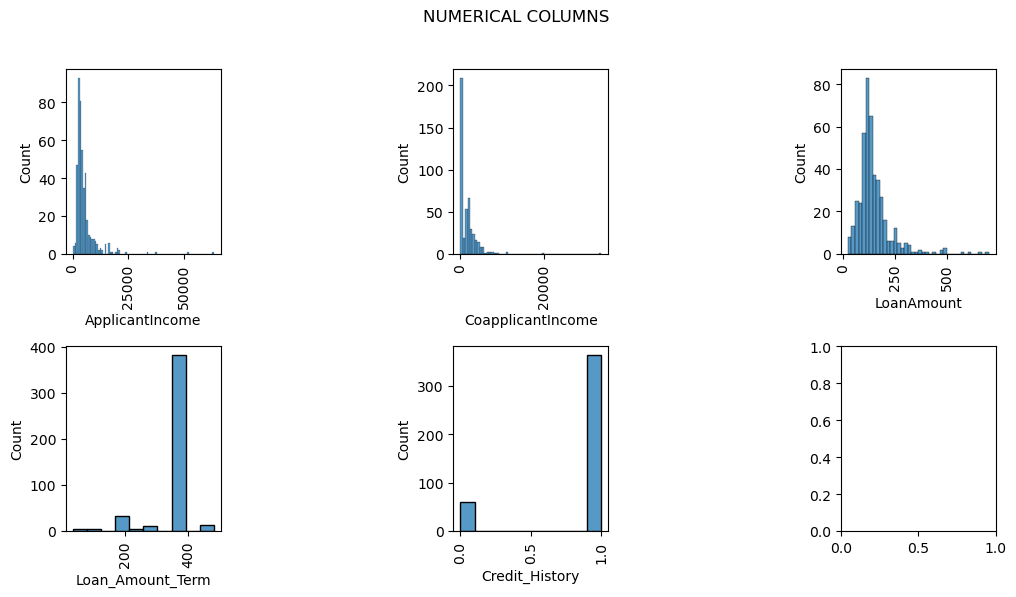

In [11]:
num = get_numcolumns(df_train)
n_cols = 3
n_rows = (len(num) - 1) // n_cols + 1

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6))
fig.subplots_adjust(hspace=0.5, wspace=1.5)
fig.suptitle('NUMERICAL COLUMNS')

for i, column in enumerate(num):
    ax = axes.flat[i]
    sns.histplot(x=df_train[column], ax=ax)
    ax.set_xlabel(num[i])
    ax.tick_params(axis='x', labelrotation=90)

plt.show()


## Checking for Outliers


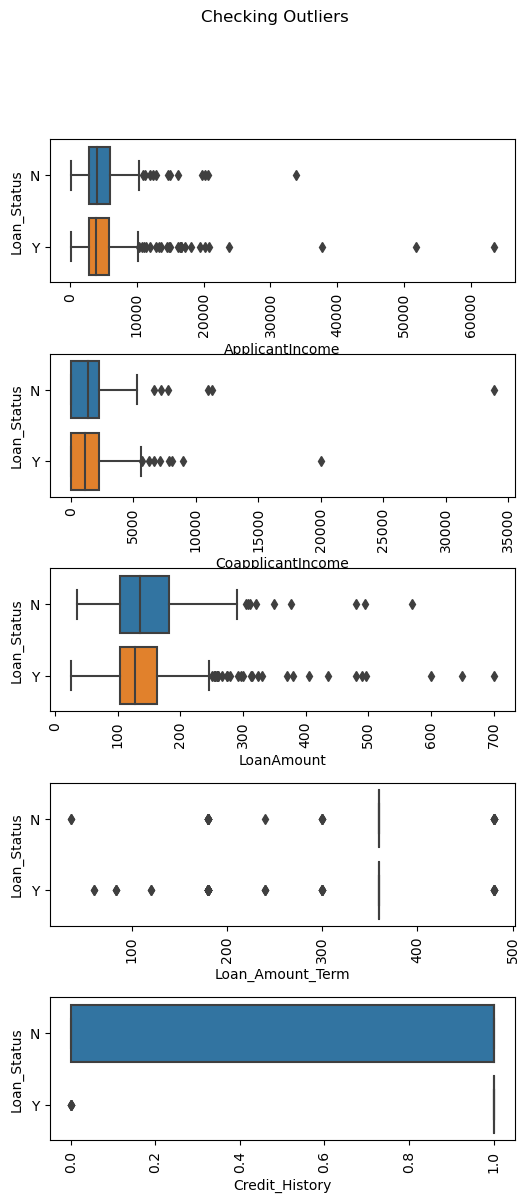

In [12]:
num = get_numcolumns(df_train)
n_cols = 1
n_rows = (len(num) - 1) // n_cols + 1

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6, 13))
fig.subplots_adjust(hspace=0.5, wspace=1.5)
fig.suptitle('Checking Outliers')

for i, column in enumerate(num):
    ax = axes.flat[i]
    sns.boxplot(data=df_train, x=df_train[column],y='Loan_Status', ax=ax)
    ax.set_xlabel(num[i])
    ax.tick_params(axis='x', labelrotation=90)

plt.show()


In [13]:
display(pd.DataFrame(df_train.groupby('Loan_Status').ApplicantIncome.describe().unstack()))
display(pd.DataFrame(df_train.groupby('Loan_Status').CoapplicantIncome.describe().unstack()))
display(pd.DataFrame(df_train.groupby('Loan_Status').LoanAmount.describe().unstack()))

0
      Loan_Status              
count N              138.000000
      Y              322.000000
mean  N             5282.840580
      Y             5413.329193
std   N             4384.736970
      Y             5758.655675
min   N              150.000000
      Y              210.000000
25%   N             2924.500000
      Y             2896.250000
50%   N             4025.000000
      Y             3848.000000
75%   N             6024.750000
      Y             5813.500000
max   N            33846.000000
      Y            63337.000000

0
      Loan_Status              
count N              138.000000
      Y              322.000000
mean  N             1813.137681
      Y             1479.677019
std   N             3440.220917
      Y             1972.484161
min   N                0.000000
      Y                0.000000
25%   N                0.000000
      Y                0.000000
50%   N             1353.000000
      Y             1128.500000
75%   N             2253.000000
      Y             2250.000000
max   N            33837.000000
      Y            20000.000000

0
      Loan_Status            
count N            131.000000
      Y            316.000000
mean  N            155.282443
      Y            147.022152
std   N             85.544795
      Y             86.373476
min   N             35.000000
      Y             25.000000
25%   N            103.500000
      Y            103.750000
50%   N            135.000000
      Y            128.000000
75%   N            181.500000
      Y            162.000000
max   N            570.000000
      Y            700.000000

## Insights 
- We have missing values, we ned to handle them
- We can change Credit History to a categorical feature. 
- The numerical columns are skewed to the left, we will nomalize them using MinMAx Scaler
- We can seesome outliers in the first three Boxplots, we will handle them imputing them the value of the upper quartile. 

# Changes both in Train and Test
In this step I am applying the changes for improving the Quality of the Data for both training and test set. 
The same steps are performed in both training and test sets. 

1. Dropping null values from Credit History because it is an important feature that in my opinion shouldn't be imputed using mode. 
2. Get null columns and impute the most frequent value (mode) using Sklearn SimpleImputer.
3. After getting rid of the null, I am converting the Dependents column into a numerical feature.
4. After I just check if the changes were made, checkong again the columns, and the Null Values.
5. After checking, I handle the Outliers using a custom function.

In [14]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

#Changes to Train
null_columns_dftrain = df_train.columns[df.isnull().any()]
df_train.dropna(subset=['Credit_History'], inplace=True)
mode_imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

for column in null_columns_dftrain:
    df_train[column] = mode_imputer.fit_transform(df_train[column].values.reshape(-1,1))[:,0]

df_train['Credit_History'] = df_train['Credit_History'].astype(str)
df_train['Dependents'] = df_train['Dependents'].replace({'3+':3})
df_train['Dependents'] = df_train['Dependents'].astype(int)

#Changes to Test
null_columns_dftest = df_test.columns[df.isnull().any()]
df_test.dropna(subset=['Credit_History'], inplace=True)
for column in null_columns_dftest:
    df_test[column] = mode_imputer.fit_transform(df_test[column].values.reshape(-1,1))[:,0]
df_test['Credit_History'] = df_test['Credit_History'].astype(str)
df_test['Dependents'] = df_test['Dependents'].replace({'3+':3})
df_test['Dependents'] = df_test['Dependents'].astype(int)

print('Cat:',get_catcolumns(df_train), '\n Num:', get_numcolumns(df_train))

Cat: ['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status'] 
 Num: ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']


In [15]:
df_train.isnull().sum()


Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Handling Outliers
Getting the Quantiles for each numerical column, to each outlier. 
I will impute the value from the 50% quantile to all the values greater to the 50% quartile so I don't change the data too much.

#### Checking the quantiles for each column

In [16]:
quantiles = df_train.quantile(q=[0.25, 0.5, 0.75], axis=0, numeric_only=True)
quantiles

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
0.25,0.0,2894.75,0.0,104.00,360.0
0.50,0.0,3871.00,1188.5,128.00,360.0
0.75,1.0,5819.50,2236.5,165.25,360.0


In [17]:
def quantile_imputer(dataset, column, qvalue):
    quantile = dataset[column].quantile(q=[qvalue])
    copy= dataset[column].copy()
    for i in range(len(dataset[column])):
        if copy.iloc[i] > quantile.values:
            copy.iloc[i]=quantile.values
    dataset[column] = copy

quantile_imputer(df_train, 'ApplicantIncome', 0.50)
quantile_imputer(df_train, 'CoapplicantIncome', 0.50)
quantile_imputer(df_train, 'LoanAmount', 0.50)

#### Checking the applied changes

In [18]:
display(pd.DataFrame(df_train.groupby('Loan_Status').ApplicantIncome.describe().unstack()))
display(pd.DataFrame(df_train.groupby('Loan_Status').CoapplicantIncome.describe().unstack()))
display(pd.DataFrame(df_train.groupby('Loan_Status').LoanAmount.describe().unstack()))


0
      Loan_Status             
count N             127.000000
      Y             297.000000
mean  N            3322.125984
      Y            3345.723906
std   N             739.172499
      Y             714.877922
min   N             150.000000
      Y             210.000000
25%   N            2903.000000
      Y            2895.000000
50%   N            3871.000000
      Y            3858.000000
75%   N            3871.000000
      Y            3871.000000
max   N            3871.000000
      Y            3871.000000

0
      Loan_Status             
count N             127.000000
      Y             297.000000
mean  N             626.177165
      Y             645.372054
std   N             589.909613
      Y             580.996417
min   N               0.000000
      Y               0.000000
25%   N               0.000000
      Y               0.000000
50%   N            1188.500000
      Y            1126.000000
75%   N            1188.500000
      Y            1188.500000
max   N            1188.500000
      Y            1188.500000

0
      Loan_Status            
count N            127.000000
      Y            297.000000
mean  N            112.937008
      Y            112.515152
std   N             22.236374
      Y             24.101712
min   N             35.000000
      Y             25.000000
25%   N            103.500000
      Y            105.000000
50%   N            128.000000
      Y            128.000000
75%   N            128.000000
      Y            128.000000
max   N            128.000000
      Y            128.000000

In [19]:
df_train.shape

(424, 12)

#  Feature Engineering

### Step 1: Mapping 0 and 1 to the Y/N for target label
### Step 2: OneHotEncoder for categorical values
### Step 3: MinMax Scaler for numerical values
### Step 4: SMOTE for handling imbalanced classes

## Step 1


First I will set the X and y (Dependent and Independent variables) and will change the Y target values to numeric values 0 for No and 1 for Yes.

In [20]:
X_train = df_train.drop(columns=['Loan_Status'])
y_train = df_train['Loan_Status']
y_train.replace({'Y':1, 'N':0},inplace=True)

X_test = df_test.drop(columns=['Loan_Status'])
y_test = df_test['Loan_Status']
y_test.replace({'Y':1, 'N':0},inplace=True)

In [21]:
print('Cat:',get_catcolumns(X_train), '\n Num:', get_numcolumns(X_train))

Cat: ['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area'] 
 Num: ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']


Now we don't have the Target Label on the Columns

## Step 2 &  3
In this step I will use Column Transformer to apply the Normalization to the numerical feautures and OneHotEncoder to the categorical features. I am calling the past function for getting the respective columns. 

After getting the columns I store the classifiers so I can use them in the ColumnTransformer, the `remainder` parameter is for applying the classifiers on the selected columns and doing nothing to the rest. 

At the end I am fitting and transforming the ColumnTransformer on the train, so it knows what to do on the test when fitting the Transformer. 

In [22]:
cat = get_catcolumns(X_train)
num = get_numcolumns(X_train)
ohe = OneHotEncoder(handle_unknown='ignore')
norm = MinMaxScaler()
ct = ColumnTransformer(transformers=[('cat',ohe, cat),
                                     ('num',norm, num)
                                    ], remainder='passthrough')
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

## Step 4 
#### Smote for Imbalanced classes for Target Label

Here I am applying Smote to the imbalaced classes on the target label. We noticed that the classes were imbalance in the Data Exploration phase.

[Text(0.5, 1.0, 'Before SMOTE')]

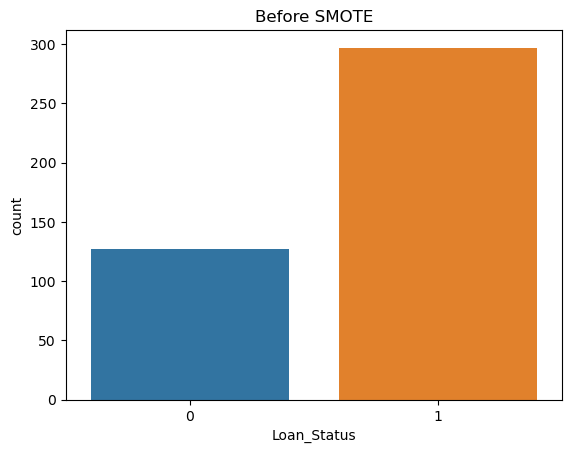

In [23]:
sns.countplot(x=y_train).set(title='Before SMOTE')

In [24]:
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

[Text(0.5, 1.0, 'After SMOTE')]

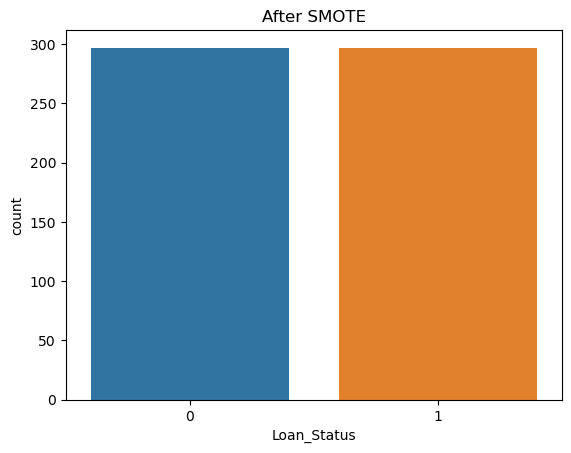

In [25]:
sns.countplot(x=y_train).set(title='After SMOTE')


# Modelling

First we create a dictionary where we are going to store the mean crossed validated scores for the best parameteres. 

The Grid Search will be using Precision as estimator, because we want to get the most True Negatives and True Positives (The Diagonal in the Confusion Matrix) values. We could se in the Data Exploration that the mayority of the loans are approved, we want to make sure that if an Applicant is worthy, the loan will be granted, and the same way around, we don't care that much if there are some not worthy people not getting the loan or viceversa. 

In [26]:
grid_scores = {'KNN': 0 , 'SVC': 0 , 'Tree': 0 }

## Using Gridsearch for KNN
Here I am using for hyperparameter tunning the number of neighbors, the weights and the algorithm. I am ignoring Future Warnings because there will be a Future Update for Scipy Library, it is not nothing to worry for the moment.

In [27]:
parameters = {'n_neighbors':[3, 6, 8, 10], 'weights':('uniform', 'distance'),
              'algorithm' :['ball_tree', 'kd_tree', 'brute']}

knn = KNeighborsClassifier()

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

clf_knn = GridSearchCV(knn,parameters, scoring='precision')

#Train the best model on the whole training set.
clf_knn.fit(X_train,y_train)
grid_scores['KNN'] = clf_knn.best_score_
clf_knn.best_params_


{'algorithm': 'brute', 'n_neighbors': 10, 'weights': 'distance'}

## Using Grid for SVC


In [28]:
parameters = {'C':[0.5,1, 1.5, 2],'kernel':['poly'],
              'gamma': ['scale'], 'degree': [3, 4, 5],'max_iter':[150000] }

svc = SVC()
clf_svc = GridSearchCV(svc,parameters, scoring='precision')

#Train the best model on the whole training set.
clf_svc.fit(X_train,y_train)
grid_scores['SVC'] = clf_svc.best_score_
clf_svc.best_params_

{'C': 1.5, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 150000}

## Using Grid for Tree

In [29]:
parameters = {'criterion':['gini', 'entropy'],'splitter':['best', 'random'],
              'max_depth': [5, 10, 15], 'min_samples_split':[2, 3, 4]}

tree = DecisionTreeClassifier()
clf_tree = GridSearchCV(tree,parameters, scoring='precision')

#Train the best model on the whole training set.
clf_tree.fit(X_train,y_train)
grid_scores['Tree'] = clf_tree.best_score_
clf_tree.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_split': 3,
 'splitter': 'random'}

Getting the cross validated precision scores for each model. Even though I am sorting the values, this doesn't mean that I will get the same score when predicting the Unseen Data, because of this I will evaluate all the models.

In [30]:
sorted_scores = sorted(grid_scores.items(), key=lambda x: x[1], reverse=True)

for classifier, score in sorted_scores:
    print(classifier, score)

Tree 0.819262992912708
SVC 0.8036240386394191
KNN 0.782819687920114


# Models Evaluation
Even if the models got a high score in the gridsearch and in the training set, this doesn't mean that it will perform with the same level of precision on the unseen data. That is why we are evaluation the models on the Test set. 

**The steps and performance evaluation is the same for each model.**

1. First I am printing the Accuracy, the Precission and the Recall. We are mostly interested in the Precision this is the metric that we want to improve for this case.

2. After I am doing a confusion matrix for visualizing the predicted and the true values, with the Confusion Matrix we can observe the True Positives and Negatives and the False Positives and Negatives to give us an idea of how good were the preedictions.

3. Then I am displaying a Precision Recall Curve for visualizing the tradeoff between precision and the recall. The AP in the legend stands for Average Precision, the higher the better. 

4. After this graph I am displaying the Area Under the Curve (AUC), this tells use the amount of True Positive vs the amount of False Positives, the bigger the area is, indicates a better Performance. 

## KNN

In [31]:
knn_predict = clf_knn.predict(X_test)

print('Accuracy:',accuracy_score(y_test, knn_predict))
print('Precision:',precision_score(y_test, knn_predict))
print('Recall:',recall_score(y_test, knn_predict))


Accuracy: 0.7
Precision: 0.7555555555555555
Recall: 0.7727272727272727


#### Confusion Matrix for KNN

<AxesSubplot:>

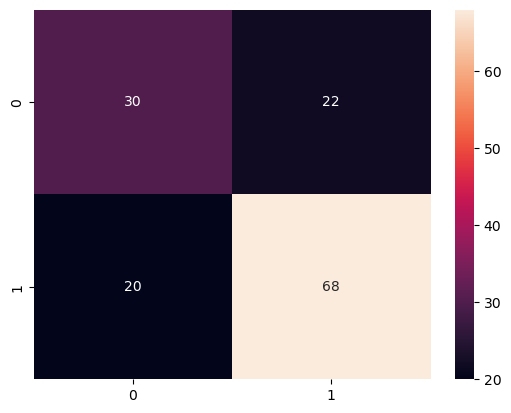

In [32]:
cf_matrix_knn = confusion_matrix(y_test, knn_predict)
sns.heatmap(cf_matrix_knn, annot=True)

#### Precision Recall Curve for KNN

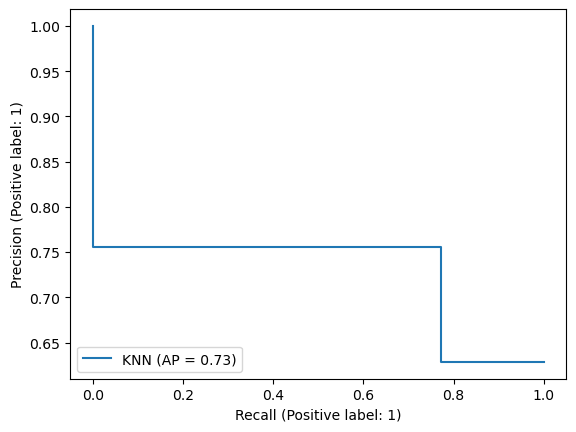

In [33]:
PrecisionRecallDisplay.from_predictions(y_test, knn_predict, name="KNN")

#### Area Under the Curve (AUC) for KNN

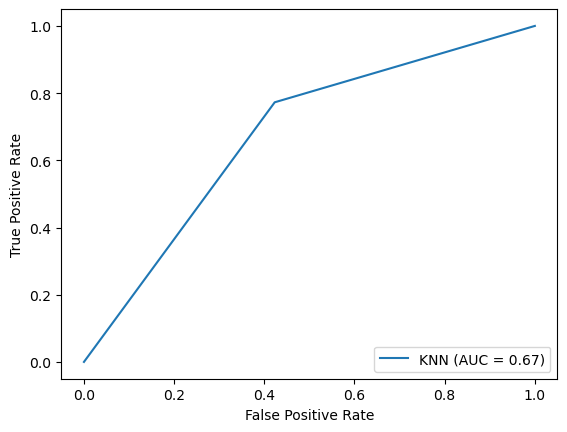

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, knn_predict)
roc_auc = auc(fpr, tpr)
knn_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='KNN')
knn_roc.plot()

## SVC

In [35]:
svc_predict = clf_svc.predict(X_test)

print('Accuracy:',accuracy_score(y_test, svc_predict))
print('Precision:',precision_score(y_test, svc_predict))
print('Recall:',recall_score(y_test, svc_predict))


Accuracy: 0.6428571428571429
Precision: 0.6759259259259259
Recall: 0.8295454545454546


#### Confusion Matrix for SVC

<AxesSubplot:>

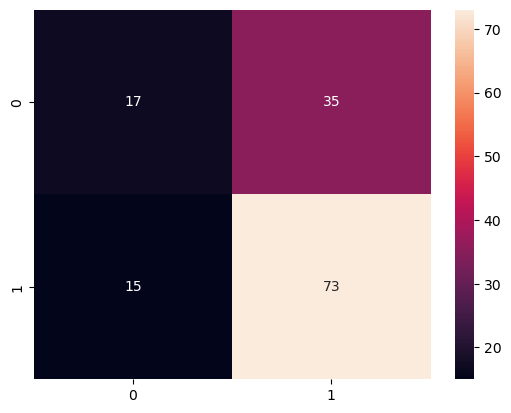

In [36]:
cf_matrix_svc = confusion_matrix(y_test, svc_predict)
sns.heatmap(cf_matrix_svc, annot=True)

#### Precision Recall Curve for SVC

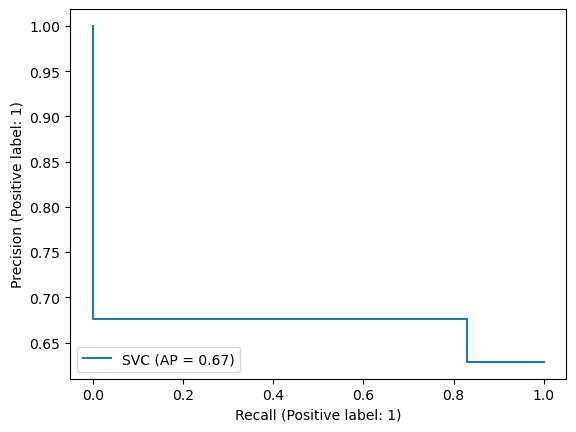

In [37]:
PrecisionRecallDisplay.from_predictions(y_test, svc_predict, name="SVC")

#### Area Under the Curve (AUC) for SVC

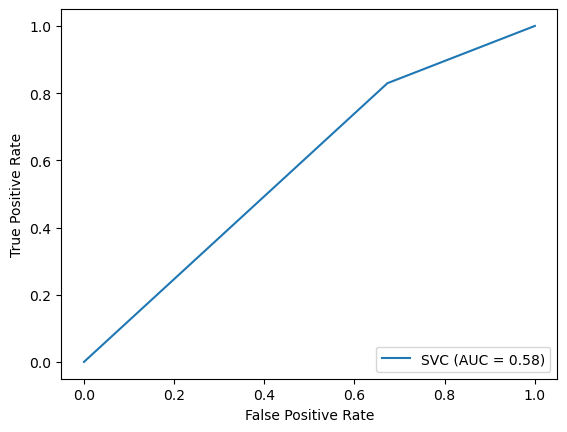

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, svc_predict)
roc_auc = auc(fpr, tpr)
svc_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='SVC')
svc_roc.plot()

## Decision Tree Classifier

In [39]:
tree_predict = clf_tree.predict(X_test)

print('Accuracy:',accuracy_score(y_test, tree_predict))
print('Precision:',precision_score(y_test, tree_predict))
print('Recall:',recall_score(y_test, tree_predict))


Accuracy: 0.6285714285714286
Precision: 0.7093023255813954
Recall: 0.6931818181818182


#### Confusion Matrix for Decision Tree Classifier

<AxesSubplot:>

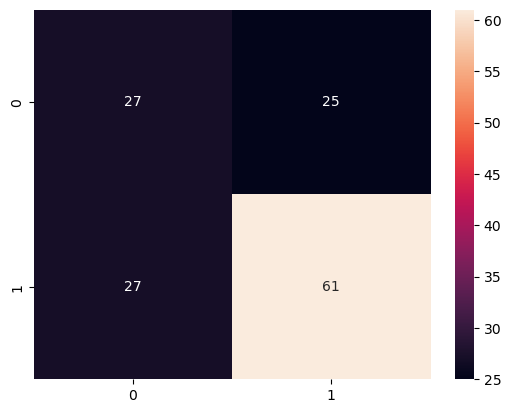

In [40]:
cf_matrix_tree = confusion_matrix(y_test, tree_predict)
sns.heatmap(cf_matrix_tree, annot=True)

#### Precision Recall Curve for Decision tree Classifier

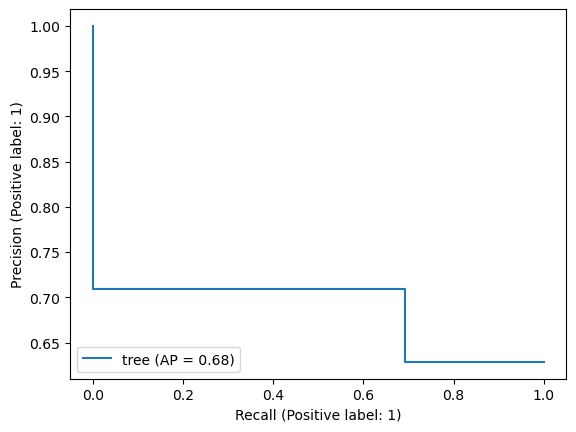

In [41]:
PrecisionRecallDisplay.from_predictions(y_test, tree_predict, name="tree")

#### Area Under the Curve (AUC) for Decision Tree Classifier

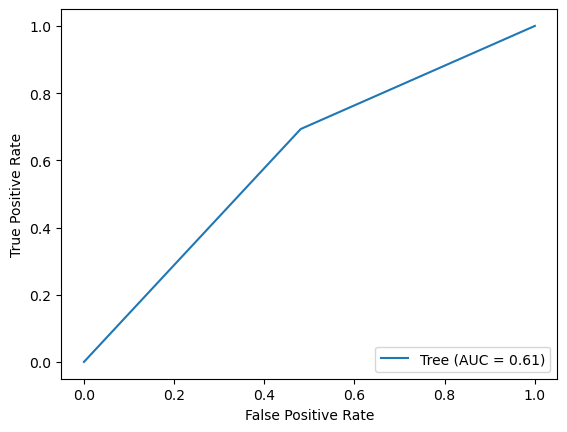

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, tree_predict)
roc_auc = auc(fpr, tpr)
tree_roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Tree')
tree_roc.plot()

# Conclussion

For this task I conducted an End to End Machine Learning Pipeline for predicting the Loan Eligibility for customers. This task was proposed by the Company in order to automate this process. By doing this we can improve the company's productivity by delegating this task to a machine. 

In this case, the model evaluation shows us how even though KNN was not the best performing model in the gridsearch, it ended up being the best model in the real case scenario by predcting the unseen data. The Evaluation metrics shows better metrics in terms of Precision and True Positives vs False Positives ratio. 

**Limitations** 

It is important to mention that this model is not 100% accurate, as for today I would not recommend to fully delegate the Eligibility Task to a machine, but it will make the task simpler for employees. This is because right now the model is really good at predicting customers that are Elegible for a House Loan. I would suggest getting more data for improving the model, so it can analyze and predict better the people that are NOT Elegible for a House Loan. 

**Explanation of the Pipeline** 

First a Data Exploration was made for detecting quality issues on the Data, things such as null values, outliers, distributions etc. After detecting the quality issues I put hands on cleaning the data and applying the changes for making the Quality better, so the predicting models perform better. Once finished cleeaning the data, a transformation was made on the values, so it can be easily read and interpreted by the different models and algorithms. At this point I performed Hyperparameter tunning to get the best parameters for each algorithm. At the end I predicted the values from the unseen data using the algorithms and the best parameters. 

The best algorithm in this case is K Neighrest Neighbors Classifier Algorithm, in simple terms, what this does it is it learns from the training data and when it gets new data points it computes the distances between points and then classifies depending on the closest points aka 'Nearest Neighbors'.

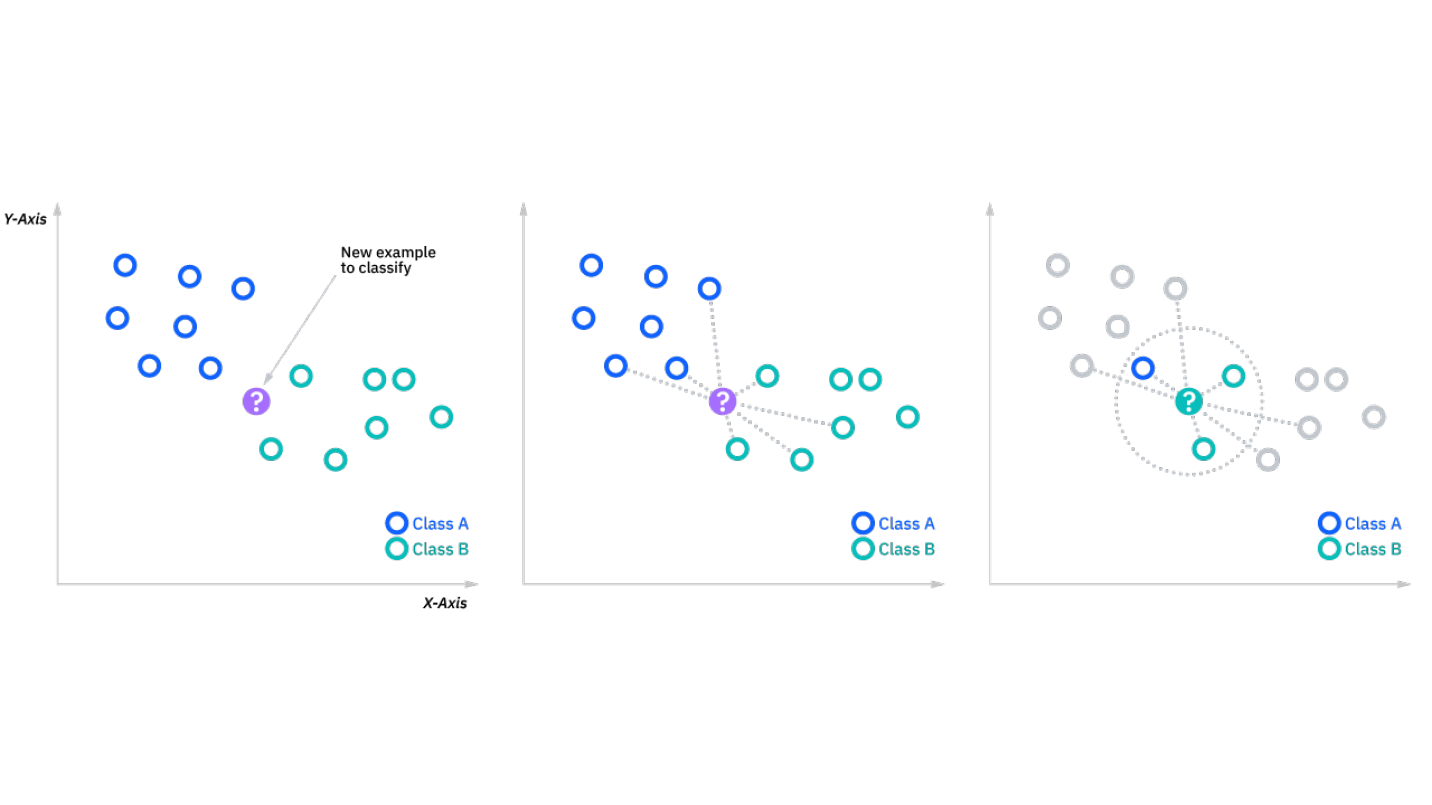

In [44]:
from IPython.display import Image

Image(filename='KNN explanation.png')

# Citation

- KNN Diagram

IBM, KNN Diagram, PNG, accessed 22 March 2023,https://www.ibm.com/topics/knn

# Submission Form

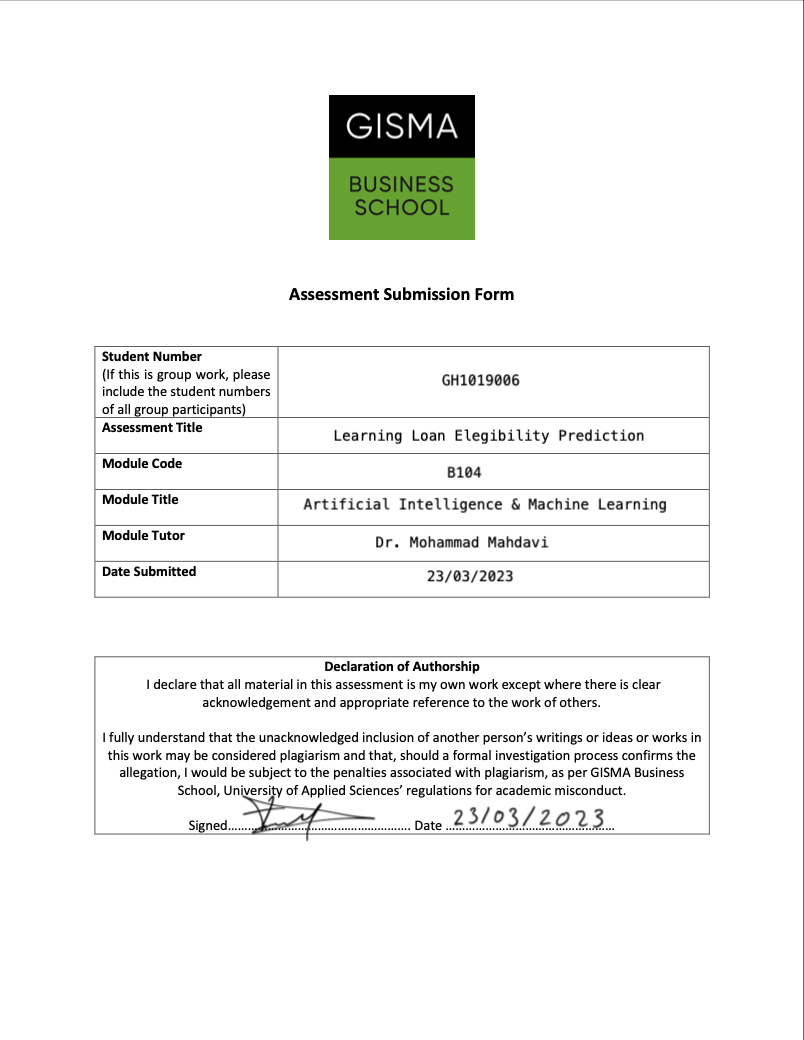

In [43]:
from IPython.display import Image

Image(filename='AI&ML submission form.png')